<a href="https://colab.research.google.com/github/ktpeters/SOC-Change-in-Farmer-Fields-22-23/blob/main/(Thesis)_CBA_22_23_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.9 MB/s eta 0:00:00


In [ ]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.7 MB/s eta 0:00:00


In [ ]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.transform
import rasterio.mask
import rasterio.warp
import rasterio.windows
import rasterstats
import pandas as pd
from scipy.signal import savgol_filter

# for 3d plotting
from mpl_toolkits.mplot3d import Axes3D
# color
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

from rasterstats import zonal_stats
from shapely.geometry import LineString
from rasterio import features
from shapely.geometry import shape

# Machine Learning
'''import scipy as sp
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate'''

'import scipy as sp\nimport scipy.stats as stats\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.model_selection import KFold\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.model_selection import cross_validate'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the yield and SOC data
file_path = r'/content/drive/MyDrive/crop-yield-estimations-20-23.dta'
yield_df = pd.read_stata(file_path)

file_path = r'/content/drive/MyDrive/n111_soc_2022_data.dta'
SOC22_df = pd.read_stata(file_path)

#file_path = r'/content/drive/MyDrive/reshaped_SOC_data_23.csv'
file_path = r'/content/drive/MyDrive/n30_appended_soc_data_nrri_04032024.dta'
SOC23_df = pd.read_stata(file_path)


In [ ]:
yield_df

,unique_id,village,plot_size_hectares,yield_per_hectare_20,yield_per_hectare_21,yield_per_hectare_22,yield_per_hectare_23,crop_cut_yield_per_hectare
0,10207063,ENDARAPADA,0.202340,5930.611816,6919.046875,7413.264648,6919.046875,5177.066406
1,10106052,SIHA,0.232691,6446.316895,6876.071777,6446.316895,7735.580566,5866.911133
2,10208079,SALAPADA,0.303510,1976.870605,6589.568359,2306.348877,4942.176270,4636.161621
3,10311093,DARPANI,0.222574,6739.331543,7188.620605,5391.465332,4492.887695,4666.891113
4,10515101,KHATUAPADA,0.202340,8401.700195,8895.916992,11119.896484,9884.352539,4505.380859
...,...,...,...,...,...,...,...,...
103,20616130,TARANGIA,0.202340,1976.870605,2471.088135,4447.958496,4942.176270,4271.007812
104,20616133,TARANGIA,0.374329,4007.170166,4541.459473,5877.183105,6678.616699,4376.892578
105,20413139,TOTAKANA,0.182106,5491.307129,4942.176270,7687.830078,4942.176270,NaN
106,10105045,MANGARAJPUR,0.252925,5930.611816,7116.733887,7907.482422,4744.489258,4751.023438


#All Yield Calculations

In [ ]:
yieldt = yield_df.rename(columns={'yield_per_hectare_20': 2020,
                         'yield_per_hectare_21': 2021,
                         'yield_per_hectare_22': 2022,
                         'yield_per_hectare_23': 2023})
yieldt.head()


,unique_id,village,plot_size_hectares,2020,2021,2022,2023,crop_cut_yield_per_hectare
0,10207063,ENDARAPADA,0.202340,5930.611816,6919.046875,7413.264648,6919.046875,5177.066406
1,10106052,SIHA,0.232691,6446.316895,6876.071777,6446.316895,7735.580566,5866.911133
2,10208079,SALAPADA,0.303510,1976.870605,6589.568359,2306.348877,4942.176270,4636.161621
3,10311093,DARPANI,0.222574,6739.331543,7188.620605,5391.465332,4492.887695,4666.891113
4,10515101,KHATUAPADA,0.202340,8401.700195,8895.916992,11119.896484,9884.352539,4505.380859


In [ ]:
yield_2223=pd.melt(yieldt.loc[:, ['unique_id', 'plot_size_hectares','village',
                                    2022,
                                    2023]],
                   id_vars=['unique_id','plot_size_hectares','village'],
                   var_name='year', value_name='yield_per_hectare')
#yield only for 2022 and 2023
yield_2223dd = yieldt[['unique_id','plot_size_hectares','village', 2022, 2023]]
yield_2223
SOC23id= SOC23_df[['unique_id', 'assignment']]
yield_2223id=  yield_2223.merge(SOC23id, on=['unique_id'], how='inner')[["year", "yield_per_hectare", "assignment", 'plot_size_hectares']]

###Yield graph

In [ ]:
yield_2023=pd.melt(yieldt.loc[:, ['unique_id',
                                   2020,
                                   2021,
                                    2022,
                                    2023]],
                   id_vars=['unique_id'],
                   var_name='year', value_name='yield_per_hectare')
SOC23id= SOC23_df[['unique_id', 'assignment']]
yield20_23=  yield_2023.merge(SOC23id, on=['unique_id'], how='inner')[["year", "yield_per_hectare", "assignment"]]
yield20_23c= yield20_23[yield20_23['assignment'] == "Control"].groupby('year')['yield_per_hectare'].mean().reset_index()
yield20_23t= yield20_23[yield20_23['assignment'] == "Treatment"].groupby('year')['yield_per_hectare'].mean().reset_index()
#yield20_23= yield20_23.groupby('year')['yield_per_hectare'].mean().reset_index()
#yield20_23[yield20_23['assignment'] == "Treatment"]

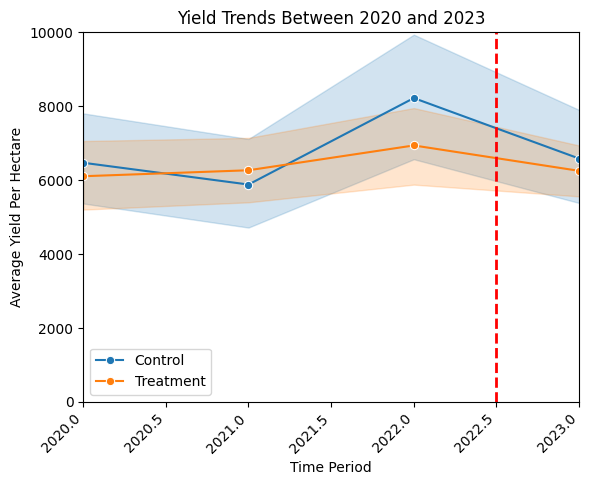

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
data = {'year': yield20_23["year"],
        'Group': yield20_23["assignment"],
        'yield': yield20_23["yield_per_hectare"]}
df = pd.DataFrame(data)

# Line plot
sns.lineplot(data=df, x='year', y='yield', hue='Group', marker='o')
plt.axvline(x=2022.5, color='r', linestyle='--', linewidth=2)
plt.title('Yield Trends Between 2020 and 2023')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time Period')
plt.ylim(0, 10000)
plt.xlim(2020,2023)
plt.legend(loc='lower left')
plt.ylabel('Average Yield Per Hectare')
plt.show()

In [ ]:
yield_2223id['plot_size_hectares'].mean()

np.float32(0.2819678)

In [ ]:
numvillages=yield_2223id['village'].nunique()
numvillages

In [ ]:
SOC23id= SOC23_df[['unique_id', 'assignment']]
yield_2223id= yield_2223dd.merge(SOC23id, on=['unique_id'], how='inner')
yield_2223diff= yield_2223id[['assignment','2022', '2023']]
#yield_2223.pivot_table(index=["unique_id", "assignment"],columns='year').stack(level=0)
mean_yieldctrl_before=yield_2223diff.groupby('assignment').mean().iloc[0, 0]
mean_yieldctrl_before
yield_2223diff.head()

###Diff in Diff with 2022 and 2023 yield data

In [ ]:
#DID in mean yield increaseid
mean_yieldctrl_before = yield_2223diff.groupby('assignment').mean().iloc[0, 0]
mean_yieldctrl_after = yield_2223diff.groupby('assignment').mean().iloc[0, 1]
mean_ytr_before = yield_2223diff.groupby('assignment').mean().iloc[1, 0]
mean_ytr_after = yield_2223diff.groupby('assignment').mean().iloc[1, 1]

print(f'mean ctrl group yield 2022: {mean_yieldctrl_before:.2f}')
print(f'mean ctrl group yield 2023: {mean_yieldctrl_after:.2f}')
print(f'mean treatment group yield 2022: {mean_ytr_before:.2f}')
print(f'mean treatment group yield 2023: {mean_ytr_after:.2f}')

ctrl_diff = mean_yieldctrl_after - mean_yieldctrl_before
treatment_diff = mean_ytr_after - mean_ytr_before
did = treatment_diff - ctrl_diff

print(f'DID in mean SOC is {did:.2f}')

In [ ]:
yield_2223diff.index
yield_2223diff.columns
yield_reset = yield_2223diff.reset_index()
yield_reset.columns
yield_reset["assignment"]= yield_reset['assignment'].replace({'Control': 0, 'Treatment': 1})
yield_reset["assignment"] = pd.to_numeric(yield_reset["assignment"], errors='coerce')

In [ ]:
# group g: 0 control group, 1 treatment group
# t: 0 before treatment, 1 after treatment
# gt: interaction of g * t

# data before the treatment
df_before = yield_reset[['2022','assignment']]
df_before['t'] = 0
df_before.columns = ['Yield', 'g', 't']

# data after the treatment
df_after = yield_reset[['2023', 'assignment']]
df_after['t'] = 1
df_after.columns = ['Yield', 'g', 't']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction
df_reg['gt'] = df_reg.g * df_reg.t

In [ ]:
'''# regression via sklearn
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.Yield

# Drop rows with NaN values in the target variable 'Yield'
df_reg = df_reg.dropna(subset=['Yield'])

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID'''

In [ ]:
'''# result is significant

from statsmodels.formula.api import ols
ols = ols('Yield ~ g + t + gt', data=df_reg).fit()
print(ols.summary())'''

###one-tailed t-test

# All SOC calculations

In [ ]:
#ml_SOC_stock is taken from 2023 (midline). SOC_stock_t_Cha_015	 is the original 2022 data
SOC23_df.rename(columns={'bl_SOC_stock_t_Cha_015': 'bl_SOC_stock_015',
                         'bl_SOC_stock_t_Cha_1530': 'bl_SOC_stock_1530',
                         'ml_soc_stock_015': 'ml_SOC_stock_015',
                         'ml_soc_stock_1530': 'ml_SOC_stock_1530' },
                  inplace=True)
SOC23_df.head()

#SOC at 0-15 cm  

In [ ]:
SOC23_df.iloc[0]
SOC23_df['diff'] = SOC23_df['ml_SOC_stock_015'] - SOC23_df['bl_SOC_stock_015']
soc23group1= SOC23_df.groupby('assignment').mean(numeric_only=True)
soc23_015= soc23group1[['bl_SOC_stock_015', 'ml_SOC_stock_015']]
soc23_015

In [ ]:
soc23group= SOC23_df.groupby('assignment').mean(numeric_only=True)
soc23group['diff']

####Diff in Diff based on SOC stock 0-15

In [ ]:
#DID in mean SOC stock increase 0-15cm
mean_SOCctrl_before = soc23_015.groupby('assignment').mean().iloc[0, 0]
mean_SOCctrl_after = soc23_015.groupby('assignment').mean().iloc[0, 1]
mean_SOCtr_before = soc23_015.groupby('assignment').mean().iloc[1, 0]
mean_SOCtr_after = soc23_015.groupby('assignment').mean().iloc[1, 1]

print(f'mean ctrl group SOC 2022: {mean_SOCctrl_before:.2f}')
print(f'mean ctrl group SOC 2023: {mean_SOCctrl_after:.2f}')
print(f'mean treatment group SOC 2022: {mean_SOCtr_before:.2f}')
print(f'mean treatment group SOC 2023: {mean_SOCtr_after:.2f}')

ctrl_diff = mean_SOCctrl_after - mean_SOCctrl_before
treatment_diff = mean_SOCtr_after - mean_SOCtr_before
did = treatment_diff - ctrl_diff

print(f'DID in mean SOC is {did:.2f}')

In [ ]:
SOC_2223diff=SOC23_df[['assignment','bl_SOC_stock_015', 'ml_SOC_stock_015']]
SOC_reset = SOC_2223diff.reset_index()
SOC_reset.columns
SOC_reset["assignment"]= SOC_reset['assignment'].replace({'Control': 0, 'Treatment': 1})
SOC_reset["assignment"] = pd.to_numeric(SOC_reset["assignment"], errors='coerce')

In [ ]:
# group g: 0 control group, 1 treatment group
# t: 0 before treatment, 1 after treatment
# gt: interaction of g * t

# data before the treatment
df_before = SOC_reset[['bl_SOC_stock_015','assignment']]
df_before['t'] = 0
df_before.columns = ['SOC', 'g', 't']

# data after the treatment
df_after = SOC_reset[['ml_SOC_stock_015', 'assignment']]
df_after['t'] = 1
df_after.columns = ['SOC', 'g', 't']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction
df_reg['gt'] = df_reg.g * df_reg.t

In [ ]:
# regression via sklearn
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.SOC

# Drop rows with NaN values in the target variable 'SOC'
df_reg = df_reg.dropna(subset=['SOC'])

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID

In [ ]:
# result is significant

from statsmodels.formula.api import ols
ols = ols('SOC ~ g + t + gt', data=df_reg).fit()
print(ols.summary())

###One-tailed t-test

In [ ]:
SOC_2223diff.head()
SOC_2223diff['diff']=SOC_2223diff['ml_SOC_stock_015']-SOC_2223diff['bl_SOC_stock_015']
SOC_2223diff.head()
treatment_diff=SOC_2223diff[SOC_2223diff['assignment']=='Treatment']['diff']
control_diff=SOC_2223diff[SOC_2223diff['assignment']=='Control']['diff']


In [ ]:
#One-tailed t-test
import numpy as np
from scipy.stats import ttest_ind # Import the ttest_ind function
from scipy import stats

t_stat, p_val = stats.ttest_ind(treatment_diff, control_diff, alternative="greater")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")
if p_val < 0.05:
    print("Result: Reject the null hypothesis — diff Treatment > diff Control (significant)")
else:
    print("Result: Fail to reject the null — no significant difference")

##Graph

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pre= datetime.date(2022, 4, 1)
treatment= datetime.date(2022, 5, 1)
post= datetime.date(2023, 10, 1)
x=[pre, post]
y=[11.034,10.498816]

# Sample data (replace with your actual data)
data = {'year': [pre, post, treatment, post],
        'group': ['control', 'control', 'treatment', 'treatment'],
        'SOC Stock': [soc23_015.iloc[0, 0], soc23_015.iloc[0, 1], soc23_015.iloc[1, 0], soc23_015.iloc[1, 1]]}
df = pd.DataFrame(data)

# Line plot
sns.lineplot(data=df, x='year', y='SOC Stock', hue='group', marker='o')
plt.plot(x, y, linestyle='dotted', label='Dotted Line')
plt.axvline(x=treatment, color='r', linestyle='--', linewidth=2)
plt.axvline(x=post, color='b', linestyle='--', linewidth=2)
plt.title('Difference-in-Differences of SOC Stock from 0-15cm')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time Period')
plt.ylabel('SOC Stock in t/ha')
plt.show()


#SOC at 15-30 cm

In [ ]:
SOC23_df.head()

In [ ]:
SOC23_df['diff2'] = SOC23_df['ml_SOC_stock_1530'] - SOC23_df['bl_SOC_stock_1530']
soc23group= SOC23_df.groupby('assignment').mean(numeric_only=True)
soc23_1530= soc23group[['bl_SOC_stock_1530', 'ml_SOC_stock_1530']]
soc23_1530


In [ ]:
soc23group= SOC23_df.groupby('assignment').mean(numeric_only=True)
soc23group['diff2']

###Diff in Diff based on SOC stock 15-30


In [ ]:
#DID in mean SOC stock increase 15-30cm
mean_SOCctrl_before = soc23_1530.groupby('assignment').mean().iloc[0, 0]
mean_SOCctrl_after = soc23_1530.groupby('assignment').mean().iloc[0, 1]
mean_SOCtr_before = soc23_1530.groupby('assignment').mean().iloc[1, 0]
mean_SOCtr_after = soc23_1530.groupby('assignment').mean().iloc[1, 1]

print(f'mean ctrl group SOC 2022: {mean_SOCctrl_before:.2f}')
print(f'mean ctrl group SOC 2023: {mean_SOCctrl_after:.2f}')
print(f'mean treatment group SOC 2022: {mean_SOCtr_before:.2f}')
print(f'mean treatment group SOC 2023: {mean_SOCtr_after:.2f}')

ctrl_diff = mean_SOCctrl_after - mean_SOCctrl_before
treatment_diff = mean_SOCtr_after - mean_SOCtr_before
did = treatment_diff - ctrl_diff

print(f'DID in mean SOC is {did:.2f}')

In [ ]:
SOC23_df.head()

In [ ]:
SOC_2223diff2=SOC23_df[['assignment','bl_SOC_stock_1530', 'ml_SOC_stock_1530']]
SOC_reset2 = SOC_2223diff2.reset_index()
SOC_reset2.columns
SOC_reset2["assignment"]= SOC_reset2['assignment'].replace({'Control': 0, 'Treatment': 1})
SOC_reset2["assignment"] = pd.to_numeric(SOC_reset2["assignment"], errors='coerce')

In [ ]:
# group g: 0 control group, 1 treatment group
# t: 0 before treatment, 1 after treatment
# gt: interaction of g * t

# data before the treatment
df_before = SOC_reset2[['bl_SOC_stock_1530','assignment']]
df_before['t'] = 0
df_before.columns = ['SOC', 'g', 't']

# data after the treatment
df_after = SOC_reset2[['ml_SOC_stock_1530', 'assignment']]
df_after['t'] = 1
df_after.columns = ['SOC', 'g', 't']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction
df_reg['gt'] = df_reg.g * df_reg.t

In [ ]:
# regression via sklearn
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.SOC

# Drop rows with NaN values in the target variable 'SOC'
df_reg = df_reg.dropna(subset=['SOC'])

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID

In [ ]:
# result is significant

from statsmodels.formula.api import ols
ols = ols('SOC ~ g + t + gt', data=df_reg).fit()
print(ols.summary())

###one-tailed t-test


In [ ]:
SOC_2223diff2.head()
SOC_2223diff2['diff2']=SOC_2223diff2['ml_SOC_stock_1530']-SOC_2223diff2['bl_SOC_stock_1530']
SOC_2223diff2.head()
treatment_diff2=SOC_2223diff2[SOC_2223diff2['assignment']=='Treatment']['diff2']#.toseries()
control_diff2=SOC_2223diff2[SOC_2223diff2['assignment']=='Control']['diff2']#.toseries()


In [ ]:
#One-tailed t-test
import numpy as np
from scipy.stats import ttest_ind # Import the ttest_ind function

t_stat, p_val = stats.ttest_ind(treatment_diff2, control_diff2, alternative="greater")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")
if p_val < 0.05:
    print("Result: Reject the null hypothesis — diff Treatment > diff Control (significant)")
else:
    print("Result: Fail to reject the null — no significant difference")

##graph

In [ ]:
pre= datetime.date(2022, 4, 1)
treatment= datetime.date(2022, 5, 1)
post= datetime.date(2023, 10, 1)
x=[pre, post]
y=[soc23_1530.iloc[1, 0], soc23_1530.iloc[1, 0]-0.015154]

# Sample data (replace with your actual data)
data = {'year': [pre, post, treatment, post],
        'group': ['control', 'control', 'treatment', 'treatment'],
        'SOC Stock': [soc23_1530.iloc[0, 0], soc23_1530.iloc[0, 1], soc23_1530.iloc[1, 0], soc23_1530.iloc[1, 1]]}
df = pd.DataFrame(data)

# Line plot
sns.lineplot(data=df, x='year', y='SOC Stock', hue='group', marker='o')
plt.plot(x, y, linestyle='dotted', label='Dotted Line')
plt.axvline(x=treatment, color='r', linestyle='--', linewidth=2)
plt.axvline(x=post, color='b', linestyle='--', linewidth=2)
plt.title('Difference-in-Differences of SOC Stock from 15-30cm')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time Period')
plt.ylabel('SOC Stock in t/ha')
plt.show()


#NDVI over time graph

In [ ]:
#address = r'DataOriginal\Vegetation Indices GEE'
address=r'/content/drive/MyDrive/Vegetation Indices GEE'
list_df = []
list_error = []
for i in os.listdir(address):
    print(i)
    try:
        file_path = os.path.join(address, i)
        df = pd.read_csv(file_path, header=0)
        df = df[['date', 'path', 'B1', 'B11', 'B12',
                 'B2', 'B3', 'B4', 'B5', 'B6',
                 'B7', 'B8', 'B8A', 'B9', 'NDVI',
                 'TVI', 'EVI', 'SATVI', 'SAVI', 'MSI',
                 'GNDVI', 'GRVI', 'LSWI', 'MSAVI2', 'WDVI', 'BI',
                 'BI2', 'RI', 'CI', 'V']].copy()
        df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
        df['year'] = [x.year for x in df['date']]
        df['month'] = [x.month for x in df['date']]
        df['fieldID'] = ['10208071' if x=='C:/Users/Admin/Desktop/Shapefiles-20230504T062202Z-001/Shapefiles/10208071/10208071 shapefile.shp'
                         else '20412107' if x=='C:/Users/Admin/Desktop/Shapefiles-20230504T062202Z-001/Shapefiles/20412107|layername=20412107'
                         else x[-12:-4] for x in df['path']]
        df.drop(columns=['path'], inplace=True)
        list_df.append(df)
    except:
        list_error.append(i)

In [ ]:
NDVI_df = pd.concat(list_df)[["NDVI", "fieldID",'year','month']]
NDVI_df.head()

In [ ]:
NDVI_id= NDVI_df.merge(SOC23id, left_on='fieldID', right_on='unique_id', how='inner')[["year","month", "NDVI", "assignment"]]
NDVI_id['date'] = pd.to_datetime(NDVI_id[['year', 'month']].assign(day=1))
#yield20_23c= yield20_23[yield20_23['assignment'] == "Control"].groupby('year')['yield_per_hectare'].mean().reset_index()
#yield20_23t= yield20_23[yield20_23['assignment'] == "Treatment"].groupby('year')['yield_per_hectare'].mean().reset_index()
NDVI_group= NDVI_id.groupby(['assignment', 'date'])['NDVI'].mean().reset_index()
NDVI_group

In [ ]:
treatment= datetime.date(2022, 5, 1)
NDVIdata = {'date': NDVI_id["date"],
        'Group': NDVI_id["assignment"],
        'NDVI': NDVI_id["NDVI"]}
dfN = pd.DataFrame(NDVIdata)

# Line plot
sns.lineplot(data=dfN, x='date', y='NDVI', hue='Group', marker='o')
plt.axvline(x=treatment, color='r', linestyle='--', linewidth=2)
plt.title('NDVI trends between 2019 and 2024')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time Period')
plt.ylabel('Average NDVI')
plt.show()